In [1]:
import sys
import os
import time
import numpy as np
from typing import List
import matplotlib.pyplot as plt

import parse
import features
import plot
import classification
from classification import GaussianNaiveBayesClassifier, KNNClassifier

### Data preprocessing

In [2]:
# Specify path to raw data file.
RAW_DATA_FILE = os.path.join(os.environ["HOME"], "data", "accelerometer", "WISDM_ar_v1.1", "WISDM_ar_v1.1_raw.txt")

# Random number generator seeds
TRAIN_TEST_SHUFFLE_SEED = 6


In [3]:
# Load data
raw_data = parse.file_to_string(RAW_DATA_FILE)
raw_measurements = parse.timepoint_strings_to_timepoint_tuples(
    parse.raw_data_string_to_timepoint_strings(raw_data)
)
user_ids = parse.extract_user_set(raw_measurements)
activities = parse.extract_activity_set(raw_measurements)
print(activities)
print(user_ids)

{'Sitting', 'Upstairs', 'Jogging', 'Standing', 'Walking', 'Downstairs'}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [4]:
# Parse raw data into 10 second intervals.
nanoseconds_in_one_second = 1000000000
nanoseconds_in_10_seconds = 10000000000
intervals: dict = parse.intervals_by_user_and_activity(
    raw_measurements,
    interval_duration_in_nanoseconds=nanoseconds_in_10_seconds,
    maximum_gap_in_nanoseconds=(nanoseconds_in_one_second * 2)
)

In [5]:
# Calculate features for all data intervals
features = features.vectors_for_intervals(
    intervals,
    (features.mean_absolute_magnitude_change_per_second, features.mean_angle_change_per_second)
)


In [6]:
# Create train and test sets.
def _shuffled_sequence(length):
    seq = list(range(length))
    np.random.shuffle(seq)  # Numpy does this in place.
    return tuple(seq)

# Create train-test folds of user ids.
np.random.seed(TRAIN_TEST_SHUFFLE_SEED)
sequence = _shuffled_sequence(len(user_ids))
folds_user_ids = classification.train_test_folds(list(user_ids), sequence, 3)


In [7]:
# Create train and test data sets.
train_features = parse.collect_dict_values_by_listed_key_contents(features, folds_user_ids[0][0])
test_features = parse.collect_dict_values_by_listed_key_contents(features, folds_user_ids[0][1])


### Gaussian Naive Bayes

In [8]:
# Fit Gaussian naive Bayes classifier.
nb_classifier = classification.GaussianNaiveBayesClassifier(train_features, activities)

In [9]:
# Example prediction of a class given a feature vector.
nb_classifier.predict_from_feature_vector((125, 20))

'Jogging'

0.8214474379292129


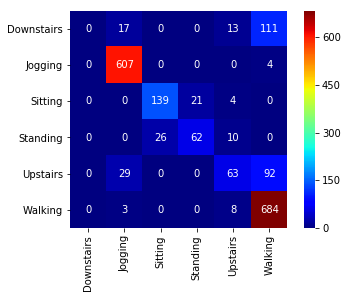

In [10]:
# Make predictions for the test set and plot confusion matrix.
gnb_pairs = nb_classifier.predicted_and_labeled_pairs(test_features)
gnb_matrix, gnb_labels = classification.confusion_matrix_from_pairs(gnb_pairs)
plot.confusion_matrix(gnb_matrix, gnb_labels)
print(classification.accuracy_from_confusion_matrix(gnb_matrix))

### k-Nearest Neighbors

In [11]:
# Instantiate kNN classifier with training data.
k = 11
knn_classifier = KNNClassifier(train_features)

In [12]:
# Example prediction of a class given a feature vector.
knn_classifier.predict_from_feature_vector((125, 20), k)

'Jogging'

In [13]:
# Make predictions for the test set and plot confusion matrix.
start_time = time.time()
knn_pairs = knn_classifier.predicted_and_labeled_pairs(test_features, k)
print("%s seconds taken to classify test set." % (time.time() - start_time))

51.30908393859863 seconds taken to classify test set.


0.7580559957739038


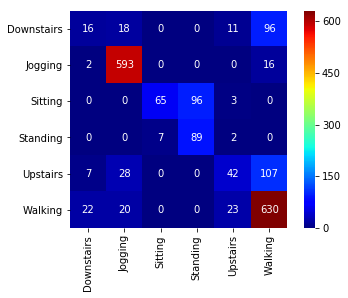

In [14]:
knn_matrix, knn_labels = classification.confusion_matrix_from_pairs(knn_pairs)
plot.confusion_matrix(knn_matrix, knn_labels)
print(classification.accuracy_from_confusion_matrix(knn_matrix))